# **Distal tibiofibular joint segmentation in CT**
## *UNet with 5 stacked slices + data augmentation*
**Authors:** Isha Dev, Liora Dsilva

In [ ]:
# Set up and imports

import os
import argparse
import pandas as pd
import numpy as np
import csv
from tqdm import tqdm
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
from torchvision import transforms
from matplotlib.colors import ListedColormap, BoundaryNorm
import torch.nn.functional as F
from ipywidgets import interact, IntSlider
import matplotlib.pyplot as plt
from collections import Counter
import albumentations as A

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Load and process data**

In [ ]:
# Load data and get keys
DATA_PATH = '/content/drive/MyDrive/DLMI Project/Project_Data/AnkleDataset_DS4.npz'
data = np.load(DATA_PATH)
image_keys = sorted([k for k in data if k.startswith("image_")])
fib_keys = sorted([k for k in data if k.startswith("fibula_")])
tib_keys = sorted([k for k in data if k.startswith("tibia_")])
tal_keys = sorted([k for k in data if k.startswith("talus_")])

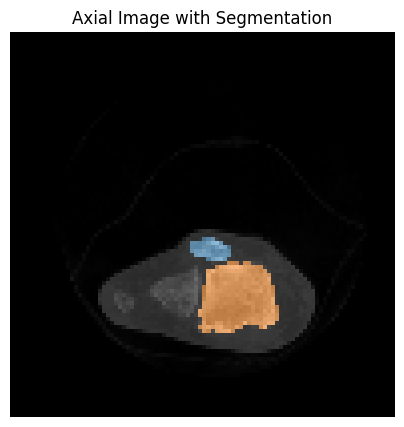

In [ ]:
# Plot an axial Example
i = 2
img = data[f'image_{i}']
seg = np.zeros_like(img, dtype=np.uint8)
seg[data[f'fibula_{i}'] == 1] = 1
seg[data[f'tibia_{i}'] == 1]  = 2
seg[data[f'talus_{i}'] == 1]  = 3

axial = img[:, :, 87]
mask  = seg[:, :, 87]
cmap  = ListedColormap(['black', '#1f77b4', '#2ca02c', '#ff7f0e'])
plt.figure(figsize=(5,5))
plt.imshow(axial, cmap='gray')
plt.imshow(mask, cmap=cmap, alpha=0.5)
plt.title("Axial Image with Segmentation")
plt.axis('off'); plt.show()

In [ ]:
# Transforms for training data
def get_training_transform():
    return A.Compose([
        A.Affine(
            scale=(0.98, 1.02),
            translate_percent=(0.01, 0.01),
            rotate=(-5, 5),
            p=0.3
        ),
        A.RandomBrightnessContrast(
            brightness_limit=0.10, contrast_limit=0.10, p=0.3
        ),
        A.GaussNoise(p=0.2),
        A.ElasticTransform(
            alpha=0.2, sigma=5, approximate=True, p=0.2
        )
    ])

train_transform = get_training_transform()

class AxialDataset(Dataset):
    def __init__(self, npz_path, include_ids=None, transform = None, crop_size=128, min_voxels=0):
        # Load data from the .npz file
        self.data = np.load(npz_path)
        self.crop_size = crop_size          # Target size for output slices
        self.transform = transform          # Data augmentation
        self.min_voxels = min_voxels
        self.index_map = []

        # Containers
        self.images = []
        self.fibs = []
        self.tibs = []
        self.tals = []
        self.patient_ids = []

        # Collect axial images
        for k in sorted(self.data):
            if k.startswith("image_"):
                pid = int(k.split("_")[1])
                if include_ids is not None and pid not in include_ids:
                    continue
                self.images.append(self.data[k])
                self.patient_ids.append(pid)

        # Collect corresponding fibula, tibia, talus masks
        for key, target in zip(['fibula', 'tibia', 'talus'], [self.fibs, self.tibs, self.tals]):
            for k in sorted(self.data):
                if k.startswith(f"{key}_"):
                    pid = int(k.split("_")[1])
                    if include_ids is not None and pid not in include_ids:
                        continue
                    target.append(self.data[k])

        # Slice indices
        for i, (img, fib, tib, tal) in enumerate(zip(self.images, self.fibs, self.tibs, self.tals)):
            for z in range(img.shape[2]):
                # Build a label map (0=background, 1=fibula, 2=tibia, 3=talus)
                label = (fib[:, :, z] > 0) * 1 + (tib[:, :, z] > 0) * 2 + (tal[:, :, z] > 0) * 3
                if (label > 0).sum() >= self.min_voxels:
                    self.index_map.append((i, z))

    def __len__(self):
        # Number of eligible slices for training
        return len(self.index_map)

    def __getitem__(self, idx):
        # Get volume index and slice index
        i, z = self.index_map[idx]
        vol = self.images[i]  # [H, W, D]
        fib = self.fibs[i]
        tib = self.tibs[i]
        tal = self.tals[i]

        # Stack 5 slices: z-2 to z+2, clamped within volume bounds
        slices = []
        for offset in [-2, -1, 0, 1, 2]:
            zi = min(max(z + offset, 0), vol.shape[2] - 1)
            slice_i = vol[:, :, zi]
            slices.append(slice_i)
        img = np.stack(slices, axis=0).astype(np.float32)  # [5, H, W]

        # Single label from center slice z
        label = np.zeros_like(vol[:, :, z], dtype=np.uint8)
        label[fib[:, :, z] > 0] = 1
        label[tib[:, :, z] > 0] = 2
        label[tal[:, :, z] > 0] = 3

        # Pad/crop image and label
        img = self.pad_crop(img)
        label = self.pad_crop(label)[0]

        assert img.shape[1:] == label.shape, f"Shape mismatch: img {img.shape}, label {label.shape}"

        # Apply transform if defined (expects HWC)
        if self.transform:
            img = np.transpose(img, (1, 2, 0))  # [H, W, 5]
            augmented = self.transform(image=img, mask=label)
            img = np.transpose(augmented['image'], (2, 0, 1))  # [5, H, W]
            label = augmented['mask']

        img = torch.from_numpy(img).float()
        label = torch.from_numpy(label).long()
        return img, label

    def pad_crop(self, x):
        if x.ndim == 2:  # [H, W]
            x = x[None, :, :]  # [1, H, W]
        C, H, W = x.shape
        pad_h = max(0, self.crop_size - H)
        pad_w = max(0, self.crop_size - W)

        pad = (
            (0, 0),
            (pad_h // 2, pad_h - pad_h // 2),
            (pad_w // 2, pad_w - pad_w // 2)
        )

        x = np.pad(x, pad, mode='constant')
        return x[:, :self.crop_size, :self.crop_size]

In [ ]:
def get_patient_ids(npz_path):
  # Get files and patient ids
  data = np.load(npz_path)
  return sorted([int(k.split("_")[1]) for k in data if k.startswith("image_")])

def split_patient_ids(patient_ids, seed=42, train_frac=0.7, val_frac=0.2):
  # Random split of patient IDs into train/val/test
  random.seed(seed)
  random.shuffle(patient_ids)
  N = len(patient_ids)
  train_ids = patient_ids[:int(train_frac * N)]
  val_ids = patient_ids[int(train_frac * N):int((train_frac + val_frac) * N)]
  test_ids = patient_ids[int((train_frac + val_frac) * N):]
  return train_ids, val_ids, test_ids


In [ ]:
# Get split patient ids
all_patient_ids = get_patient_ids(DATA_PATH)
train_ids, val_ids, test_ids = split_patient_ids(all_patient_ids)

# Create datasets
train_ds = AxialDataset(DATA_PATH, include_ids=train_ids, transform=train_transform)
val_ds = AxialDataset(DATA_PATH, include_ids=val_ids)
test_ds = AxialDataset(DATA_PATH, include_ids=test_ids)

# Data loaders with batching
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=4, shuffle=False, num_workers=2)

In [ ]:
from collections import Counter

def compute_class_weights(dataset):
    counter = Counter()
    for _, label in dataset:
        for c in range(4):
            counter[c] += (label == c).sum().item()
    freqs = np.array([counter[c] for c in range(4)])
    weights = 1.0 / (freqs + 1e-6)
    return torch.tensor(weights / weights.sum(), dtype=torch.float32)

# Temporarily create an un-augmented dataset for weights
train_ds_no_aug = AxialDataset(
    npz_path=DATA_PATH,
    include_ids=train_ids,
    transform=None,
    crop_size=128,
    min_voxels=0
)

class_weights = compute_class_weights(train_ds_no_aug)

### **Model Architecture and Metrics**

In [ ]:
# UNet (with batch normalization)
class UNetWithBN(nn.Module):
  def __init__(self, in_channels=1, out_channels=4, base_filters=32):
    super(UNetWithBN, self).__init__()
    # Convolutional block
    def conv_block(in_ch, out_ch):
      return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    # Encoder (downsampling)
    self.enc1 = conv_block(in_channels, base_filters)
    self.pool1 = nn.MaxPool2d(2)

    self.enc2 = conv_block(base_filters, base_filters * 2)
    self.pool2 = nn.MaxPool2d(2)

    self.enc3 = conv_block(base_filters * 2, base_filters * 4)
    self.pool3 = nn.MaxPool2d(2)

    # Bottleneck (center)
    self.center = conv_block(base_filters * 4, base_filters * 8)

    # Decoder (upsampling)
    self.up3 = nn.ConvTranspose2d(base_filters * 8, base_filters * 4, kernel_size=2, stride=2)
    self.dec3 = conv_block(base_filters * 8, base_filters * 4)

    self.up2 = nn.ConvTranspose2d(base_filters * 4, base_filters * 2, kernel_size=2, stride=2)
    self.dec2 = conv_block(base_filters * 4, base_filters * 2)

    self.up1 = nn.ConvTranspose2d(base_filters * 2, base_filters, kernel_size=2, stride=2)
    self.dec1 = conv_block(base_filters * 2, base_filters)

    # 1x1 convolution
    self.final = nn.Conv2d(base_filters, out_channels, kernel_size=1)

  # Forward pass
  def forward(self, x):
      # Encoder forward pass
      e1 = self.enc1(x)
      e2 = self.enc2(self.pool1(e1))
      e3 = self.enc3(self.pool2(e2))
      center = self.center(self.pool3(e3))

      # Decoder forward pass with skip connections
      d3 = self.dec3(torch.cat([self.up3(center), e3], dim=1))
      d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
      d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

      # Final logits
      return self.final(d1)

def dice_score(preds, targets, num_classes=4, eps=1e-6):
    # Convert to one-hot encoding
    preds = F.one_hot(preds, num_classes).permute(0, 3, 1, 2).float()
    targets = F.one_hot(targets, num_classes).permute(0, 3, 1, 2).float()

    # Compute per-class intersection and union
    intersection = (preds * targets).sum(dim=(2, 3))
    union = preds.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))

    # Dice score with smoothing
    dice = (2 * intersection + eps) / (union + eps)

    mean_dice = dice.mean().item()  # Mean over batch and classes
    class_dice = dice.mean(dim=0).tolist()  # Per-class Dice averaged over batch
    return mean_dice, class_dice

def pixel_accuracy(preds, targets):
  correct = (preds == targets).float()
  return correct.sum().item() / correct.numel()

def train_model_sanity(model, train_loader, val_loader, class_weights, device, epochs=25, lr=1e-4, log_csv_path=None):
  model.to(device)
  # Weighted cross-entropy loss
  criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  best_dice = 0
  log_rows = [] # CSV setup
  header = ["epoch", "train_loss", "val_loss", "val_dice", "pixel_acc"] + [f"class_{i}_dice" for i in range(class_weights.shape[0])]

  # Training
  for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0
    for img, label in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} - Training"):
        img, label = img.to(device), label.to(device)

        optimizer.zero_grad()
        logits = model(img)
        loss = criterion(logits, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    all_dices = []
    all_class_dices = []
    acc_total = 0
    with torch.no_grad():
        for img, label in tqdm(val_loader, desc="Validating"):
            img, label = img.to(device), label.to(device)
            logits = model(img)
            loss = criterion(logits, label)
            val_loss += loss.item()

            preds = logits.argmax(dim=1)
            mean_dice, class_dice = dice_score(preds, label)
            acc = pixel_accuracy(preds, label)

            all_dices.append(mean_dice)
            all_class_dices.append(torch.tensor(class_dice))
            acc_total += acc

    avg_val_loss = val_loss / len(val_loader)
    avg_dice = sum(all_dices) / len(all_dices)
    avg_class_dice = torch.stack(all_class_dices).mean(dim=0).tolist()
    avg_acc = acc_total / len(val_loader)

    # Log metrics
    print(f"Epoch {epoch}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}, Dice={avg_dice:.4f}, Acc={avg_acc:.4f}")
    print("Per-Class Dice:", ["{:.4f}".format(d) for d in avg_class_dice])

    # CSV logging
    if log_csv_path:
        row = [epoch, avg_train_loss, avg_val_loss, avg_dice, avg_acc] + avg_class_dice
        log_rows.append(row)

    # Save best model
    if avg_dice > best_dice:
        best_dice = avg_dice
        torch.save(model.state_dict(), "/content/drive/MyDrive/DLMI Project/Isha_Models/Results/Model_6/best_model.pth")

  if log_csv_path:
      with open(log_csv_path, 'w', newline='') as f:
          writer = csv.writer(f)
          writer.writerow(header)
          writer.writerows(log_rows)

  print("Training complete. Best Dice: {:.4f}".format(best_dice))

### **Train Model**

In [ ]:
# Device, model and training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
model = UNetWithBN(in_channels=5, out_channels=4)
train_model_sanity(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    class_weights=class_weights,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    epochs=25,
    lr=1e-4,
    log_csv_path="/content/drive/MyDrive/DLMI Project/Isha_Models/Results/Model_6/train_log.csv"
)

Validating: 100%|██████████| 286/286 [00:01<00:00, 152.97it/s]


Epoch 1: Train Loss=1.0340, Val Loss=0.7373, Dice=0.2767, Acc=0.8564
Per-Class Dice: ['0.9185', '0.0804', '0.0633', '0.0445']


Validating: 100%|██████████| 286/286 [00:01<00:00, 167.44it/s]


Epoch 2: Train Loss=0.7295, Val Loss=0.5635, Dice=0.3611, Acc=0.9185
Per-Class Dice: ['0.9552', '0.0990', '0.1194', '0.2709']


Validating: 100%|██████████| 286/286 [00:01<00:00, 170.97it/s]


Epoch 3: Train Loss=0.6380, Val Loss=0.4629, Dice=0.4134, Acc=0.9408
Per-Class Dice: ['0.9684', '0.3255', '0.1373', '0.2226']


Validating: 100%|██████████| 286/286 [00:01<00:00, 180.08it/s]


Epoch 4: Train Loss=0.6242, Val Loss=0.3372, Dice=0.4836, Acc=0.9609
Per-Class Dice: ['0.9796', '0.2687', '0.2796', '0.4065']


Validating: 100%|██████████| 286/286 [00:01<00:00, 180.69it/s]


Epoch 5: Train Loss=0.5441, Val Loss=0.4114, Dice=0.4426, Acc=0.9439
Per-Class Dice: ['0.9705', '0.2877', '0.3678', '0.1445']


Validating: 100%|██████████| 286/286 [00:01<00:00, 179.29it/s]


Epoch 6: Train Loss=0.4809, Val Loss=0.2039, Dice=0.5946, Acc=0.9834
Per-Class Dice: ['0.9915', '0.3989', '0.4623', '0.5257']


Validating: 100%|██████████| 286/286 [00:01<00:00, 178.48it/s]


Epoch 7: Train Loss=0.4508, Val Loss=0.1859, Dice=0.6227, Acc=0.9866
Per-Class Dice: ['0.9933', '0.5287', '0.5282', '0.4406']


Validating: 100%|██████████| 286/286 [00:01<00:00, 176.90it/s]


Epoch 8: Train Loss=0.4589, Val Loss=0.1359, Dice=0.7086, Acc=0.9911
Per-Class Dice: ['0.9955', '0.5437', '0.5737', '0.7216']


Validating: 100%|██████████| 286/286 [00:01<00:00, 172.80it/s]


Epoch 9: Train Loss=0.4680, Val Loss=0.1032, Dice=0.6731, Acc=0.9852
Per-Class Dice: ['0.9924', '0.5375', '0.5103', '0.6520']


Validating: 100%|██████████| 286/286 [00:01<00:00, 163.40it/s]


Epoch 10: Train Loss=0.4174, Val Loss=0.0992, Dice=0.7517, Acc=0.9913
Per-Class Dice: ['0.9956', '0.5995', '0.5961', '0.8155']


Validating: 100%|██████████| 286/286 [00:01<00:00, 157.04it/s]


Epoch 11: Train Loss=0.3945, Val Loss=0.1004, Dice=0.6751, Acc=0.9813
Per-Class Dice: ['0.9904', '0.6761', '0.5310', '0.5031']


Validating: 100%|██████████| 286/286 [00:01<00:00, 172.51it/s]


Epoch 12: Train Loss=0.3904, Val Loss=0.0905, Dice=0.7485, Acc=0.9880
Per-Class Dice: ['0.9939', '0.6811', '0.5574', '0.7617']


Validating: 100%|██████████| 286/286 [00:01<00:00, 176.38it/s]


Epoch 13: Train Loss=0.4022, Val Loss=0.0741, Dice=0.6147, Acc=0.9844
Per-Class Dice: ['0.9920', '0.4533', '0.4042', '0.6092']


Validating: 100%|██████████| 286/286 [00:01<00:00, 175.83it/s]


Epoch 14: Train Loss=0.3701, Val Loss=0.0713, Dice=0.7256, Acc=0.9915
Per-Class Dice: ['0.9957', '0.4900', '0.5872', '0.8293']


Validating: 100%|██████████| 286/286 [00:01<00:00, 181.11it/s]


Epoch 15: Train Loss=0.3453, Val Loss=0.0759, Dice=0.6155, Acc=0.9772
Per-Class Dice: ['0.9883', '0.4874', '0.4519', '0.5344']


Validating: 100%|██████████| 286/286 [00:01<00:00, 176.77it/s]


Epoch 16: Train Loss=0.3552, Val Loss=0.0539, Dice=0.6853, Acc=0.9866
Per-Class Dice: ['0.9931', '0.5472', '0.5796', '0.6213']


Validating: 100%|██████████| 286/286 [00:01<00:00, 175.19it/s]


Epoch 17: Train Loss=0.3284, Val Loss=0.0960, Dice=0.7380, Acc=0.9910
Per-Class Dice: ['0.9954', '0.7224', '0.4507', '0.7835']


Validating: 100%|██████████| 286/286 [00:01<00:00, 174.64it/s]


Epoch 18: Train Loss=0.3945, Val Loss=0.0497, Dice=0.7675, Acc=0.9930
Per-Class Dice: ['0.9964', '0.6667', '0.6066', '0.8001']


Validating: 100%|██████████| 286/286 [00:01<00:00, 177.78it/s]


Epoch 19: Train Loss=0.3364, Val Loss=0.0785, Dice=0.7792, Acc=0.9941
Per-Class Dice: ['0.9971', '0.5866', '0.7997', '0.7334']


Validating: 100%|██████████| 286/286 [00:01<00:00, 172.47it/s]


Epoch 20: Train Loss=0.3690, Val Loss=0.0466, Dice=0.7036, Acc=0.9897
Per-Class Dice: ['0.9948', '0.4993', '0.6717', '0.6486']


Validating: 100%|██████████| 286/286 [00:01<00:00, 174.08it/s]


Epoch 21: Train Loss=0.3075, Val Loss=0.0455, Dice=0.7676, Acc=0.9920
Per-Class Dice: ['0.9959', '0.6593', '0.6753', '0.7399']


Validating: 100%|██████████| 286/286 [00:01<00:00, 176.70it/s]


Epoch 22: Train Loss=0.3040, Val Loss=0.0441, Dice=0.7839, Acc=0.9939
Per-Class Dice: ['0.9969', '0.5761', '0.7128', '0.8497']


Validating: 100%|██████████| 286/286 [00:01<00:00, 180.17it/s]


Epoch 23: Train Loss=0.2909, Val Loss=0.0395, Dice=0.7643, Acc=0.9927
Per-Class Dice: ['0.9963', '0.5904', '0.6693', '0.8012']


Validating: 100%|██████████| 286/286 [00:01<00:00, 179.23it/s]


Epoch 24: Train Loss=0.2880, Val Loss=0.0410, Dice=0.7553, Acc=0.9921
Per-Class Dice: ['0.9960', '0.6266', '0.5737', '0.8249']


Validating: 100%|██████████| 286/286 [00:01<00:00, 171.39it/s]


Epoch 25: Train Loss=0.3207, Val Loss=0.0404, Dice=0.6560, Acc=0.9886
Per-Class Dice: ['0.9942', '0.3997', '0.5929', '0.6372']
Training complete. Best Dice: 0.7839


In [ ]:
def plot_training_metrics(log_csv_path, class_labels=["Background", "Fibula", "Tibia", "Talus"]):
    df = pd.read_csv(log_csv_path)
    epochs = df['epoch']

    fig, axs = plt.subplots(1, 4, figsize=(24, 5))

    # Pixel Accuracy
    axs[0].plot(epochs, df['pixel_acc'], label="Pixel Accuracy", color='tab:blue')
    axs[0].set_title("Pixel Accuracy")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Accuracy")

    # Mean Dice
    axs[1].plot(epochs, df['val_dice'], label="Val Dice", color='tab:green')
    axs[1].set_title("Mean Dice (Validation)")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Dice Score")

    # Per-Class Dice
    axs[2].plot(epochs, df['val_dice'], label="Mean Dice", linewidth=2)
    for i, label in enumerate(class_labels):
        axs[2].plot(epochs, df[f'class_{i}_dice'], linestyle='--', label=label)
    axs[2].set_title("Per-Class and Mean Dice (Validation)")
    axs[2].set_xlabel("Epoch")
    axs[2].set_ylabel("Dice Score")
    axs[2].legend()

    # Loss (Train + Val)
    axs[3].plot(epochs, df['train_loss'], label="Train Loss", linestyle='--', color='tab:orange')
    axs[3].plot(epochs, df['val_loss'], label="Val Loss", color='tab:red')
    axs[3].set_title("Loss")
    axs[3].set_xlabel("Epoch")
    axs[3].set_ylabel("Loss")
    axs[3].legend()

    plt.tight_layout()

    plt.savefig("/content/drive/MyDrive/DLMI Project/Isha_Models/Results/Model_6/training_metrics.png", bbox_inches='tight')

    plt.show()

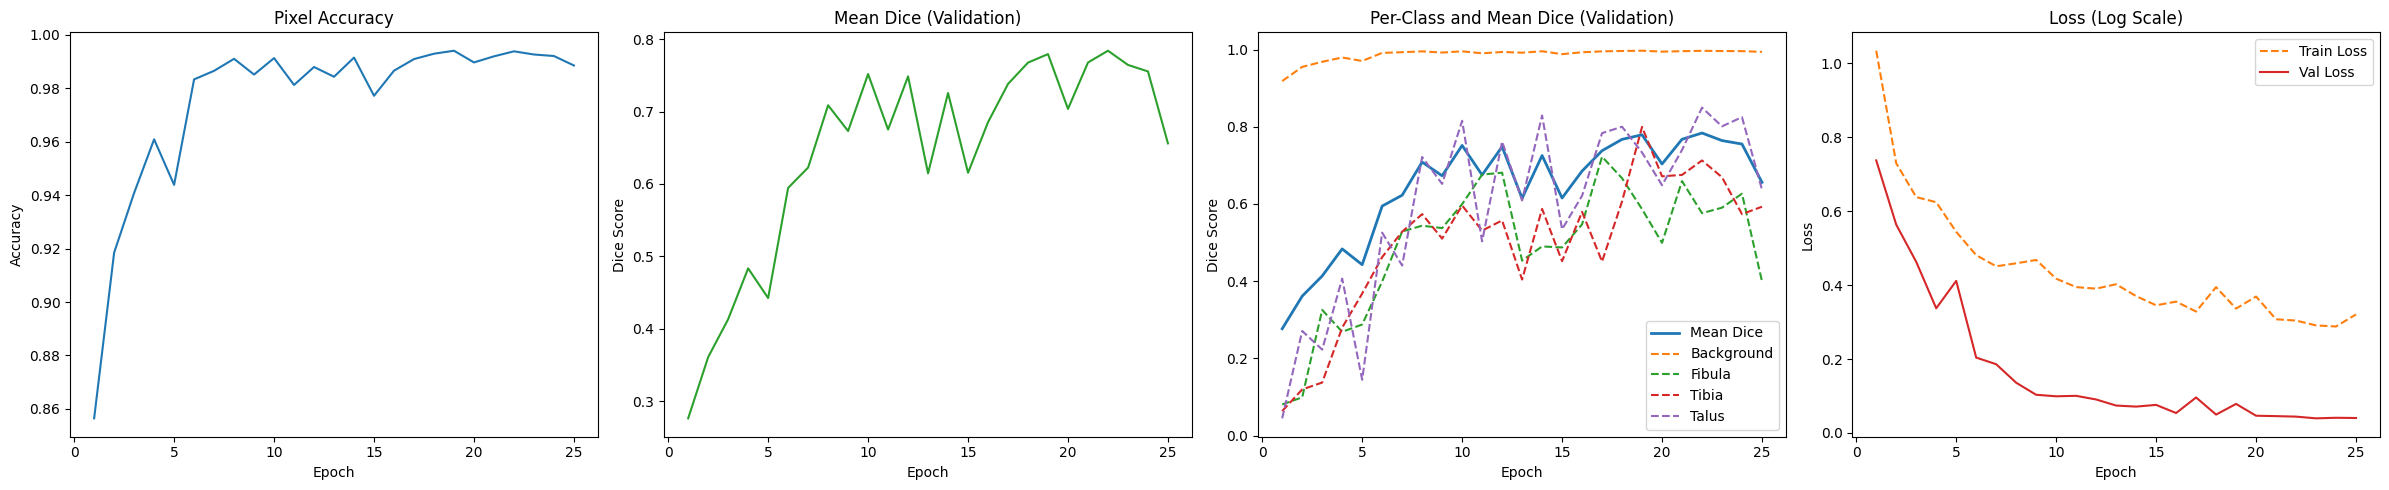

In [ ]:
plot_training_metrics("/content/drive/MyDrive/DLMI Project/Isha_Models/Results/Model_6/train_log.csv")

### **Model Evaluation**

In [ ]:
def evaluate_model(model, test_loader, device, num_classes=4):
    model.eval()
    model.to(device)

    total_loss = 0
    total_acc = 0
    all_dices = []
    all_class_dices = []

    criterion = torch.nn.CrossEntropyLoss()

    with torch.no_grad():
        for img, label in tqdm(test_loader, desc="Evaluating"):
            img, label = img.to(device), label.to(device)

            logits = model(img)
            loss = criterion(logits, label)
            total_loss += loss.item()

            preds = logits.argmax(dim=1)

            # Pixel accuracy
            acc = (preds == label).float().mean().item()
            total_acc += acc

            # Dice
            one_hot_preds = F.one_hot(preds, num_classes).permute(0, 3, 1, 2).float()
            one_hot_labels = F.one_hot(label, num_classes).permute(0, 3, 1, 2).float()

            intersection = (one_hot_preds * one_hot_labels).sum(dim=(2, 3))
            union = one_hot_preds.sum(dim=(2, 3)) + one_hot_labels.sum(dim=(2, 3))
            dice = (2 * intersection + 1e-6) / (union + 1e-6)

            all_dices.append(dice.mean().item())
            all_class_dices.append(dice.mean(dim=0))

    avg_loss = total_loss / len(test_loader)
    avg_acc = total_acc / len(test_loader)
    avg_dice = sum(all_dices) / len(all_dices)
    avg_class_dice = torch.stack(all_class_dices).mean(dim=0).tolist()

    print(f"\nTest Loss: {avg_loss:.4f}")
    print(f"Pixel Accuracy: {avg_acc:.4f}")
    print(f"Mean Dice: {avg_dice:.4f}")
    print("Per-Class Dice:", [f"{d:.4f}" for d in avg_class_dice])

    return {
        "loss": avg_loss,
        "accuracy": avg_acc,
        "mean_dice": avg_dice,
        "per_class_dice": avg_class_dice
    }

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("/content/drive/MyDrive/DLMI Project/Isha_Models/Results/Model_6/best_model.pth"))
metrics = evaluate_model(model, test_loader, device)

Evaluating: 100%|██████████| 144/144 [00:00<00:00, 170.39it/s]


Test Loss: 0.0332
Pixel Accuracy: 0.9954
Mean Dice: 0.8136
Per-Class Dice: ['0.9977', '0.6045', '0.7591', '0.8930']


In [ ]:
def plot_random_predictions(model, dataset, device, num_samples=3):
    model.eval()
    model.to(device)

    class_colors = {
        1: (1, 0, 0),   # Fibula - red
        2: (0, 1, 0),   # Tibia - green
        3: (0, 0, 1)    # Talus - blue
    }

    # Randomly sample valid indices with enough labels
    valid_indices = [i for i in range(len(dataset)) if (dataset[i][1] > 0).sum() >= 1]
    if len(valid_indices) == 0:
        print("No labeled slices found!")
        return

    # Random sample
    sampled_indices = random.sample(valid_indices, min(num_samples, len(valid_indices)))
    imgs = []
    labels = []

    for idx in sampled_indices:
        img, label = dataset[idx]
        imgs.append(img)
        labels.append(label)

    imgs = torch.stack(imgs).to(device)
    labels = torch.stack(labels)

    with torch.no_grad():
        preds = model(imgs).argmax(dim=1).cpu()

    for i in range(len(sampled_indices)):
        stack = imgs[i].cpu().numpy()
        center_img = stack[2]

        label = labels[i].numpy()
        pred = preds[i].numpy()

        fig, axs = plt.subplots(1, 3, figsize=(12, 4))

        # Input
        axs[0].imshow(center_img, cmap='gray')
        axs[0].set_title("Center Slice (Input)")
        axs[0].axis('off')

        # Ground Truth Overlay
        axs[1].imshow(center_img, cmap='gray')
        for cls, color in class_colors.items():
            axs[1].imshow((label == cls).astype(float)[..., None] * color, alpha=0.4)
        axs[1].set_title("Ground Truth Overlay")
        axs[1].axis('off')

        # Prediction Overlay
        axs[2].imshow(center_img, cmap='gray')
        for cls, color in class_colors.items():
            axs[2].imshow((pred == cls).astype(float)[..., None] * color, alpha=0.4)
        axs[2].set_title("Prediction Overlay")
        axs[2].axis('off')

        plt.tight_layout()
        plt.show()

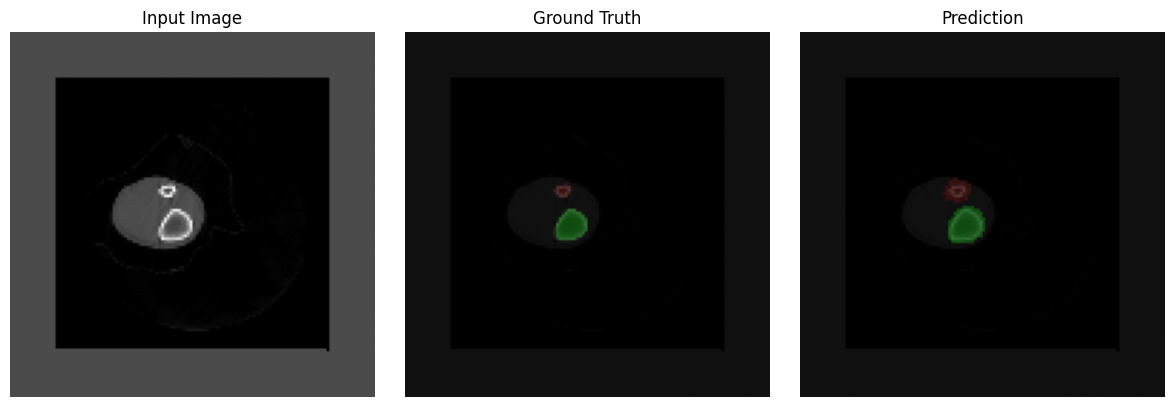

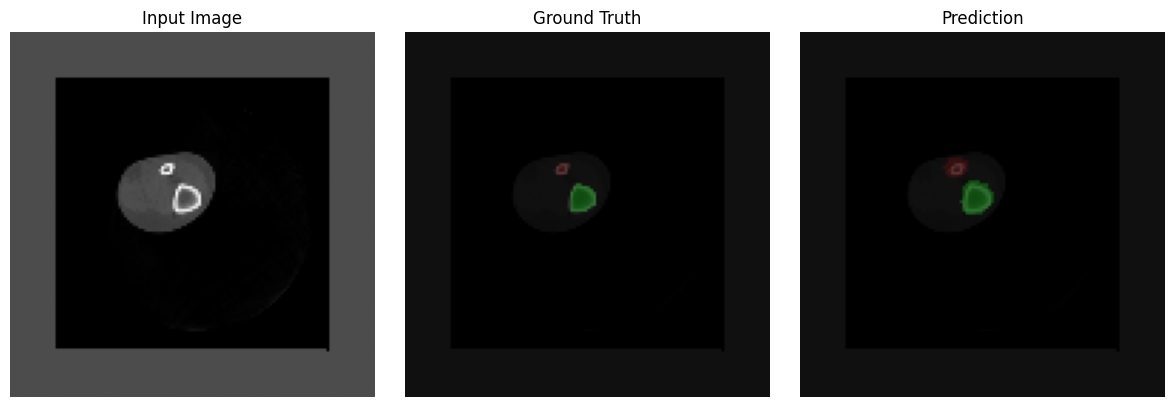

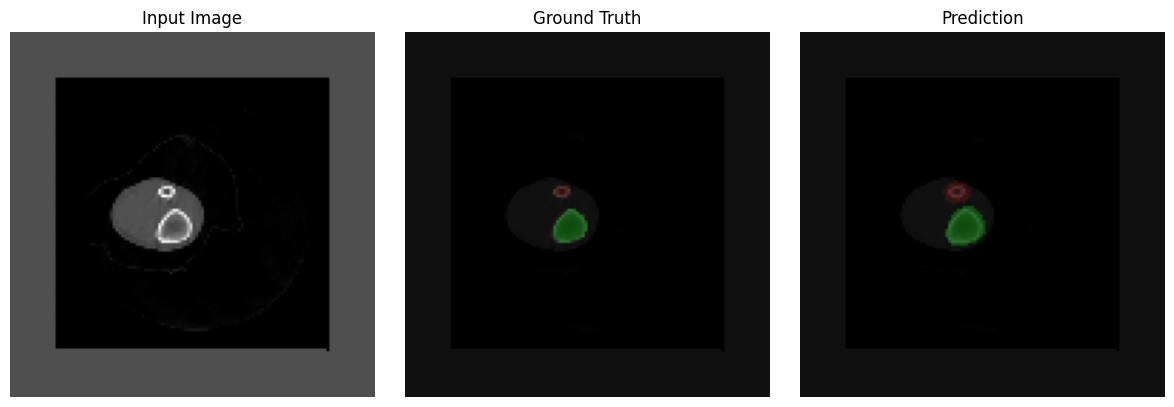

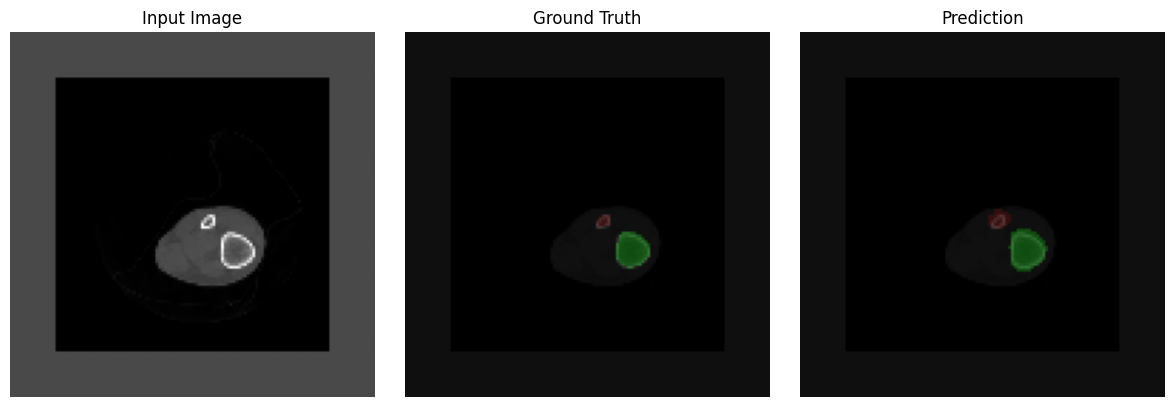

In [ ]:
plot_random_predictions(model, test_ds, device, num_samples=4)